# Chapter 6: Multicollinearity

**When Predictors Are Too Similar**

## Goal

Understand **multicollinearity** - what happens when predictors are highly correlated with each other.

**Key insights:**
- Individual predictors work fine alone
- Together, they become unstable and uncertain
- Coefficients can't be estimated precisely
- Predictions may still work, but interpretation fails

**Example**: Predicting height from left leg and right leg length

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Simulate Leg Length Data

**True generative model:**
```
height ~ Normal(10 + 2*leg_length, 1)
leg_left ~ Normal(leg_length, 0.02)  ← Almost identical
leg_right ~ Normal(leg_length, 0.02) ← Almost identical
```

Key: Left and right legs are nearly the same!

In [3]:
# Simulate data
n = 100
np.random.seed(123)

# True leg length (unobserved)
leg_length = np.random.uniform(30, 50, n)

# Observed left and right legs (with tiny measurement error)
leg_left = leg_length + np.random.normal(0, 0.02, n)
leg_right = leg_length + np.random.normal(0, 0.02, n)

# Height = roughly 2x leg length + noise
height = 10 + 2 * leg_length + np.random.normal(0, 1, n)

print(f"Simulated {n} individuals")
print(f"\nHeight: {height.mean():.1f} ± {height.std():.1f} cm")
print(f"Left leg: {leg_left.mean():.1f} ± {leg_left.std():.1f} cm")
print(f"Right leg: {leg_right.mean():.1f} ± {leg_right.std():.1f} cm")
print(f"\nCorrelation between legs: {np.corrcoef(leg_left, leg_right)[0,1]:.4f}")
print("⚠️ Left and right legs are ALMOST PERFECTLY correlated!")

Simulated 100 individuals

Height: 89.9 ± 9.7 cm
Left leg: 40.0 ± 4.9 cm
Right leg: 40.0 ± 4.9 cm

Correlation between legs: 1.0000
⚠️ Left and right legs are ALMOST PERFECTLY correlated!


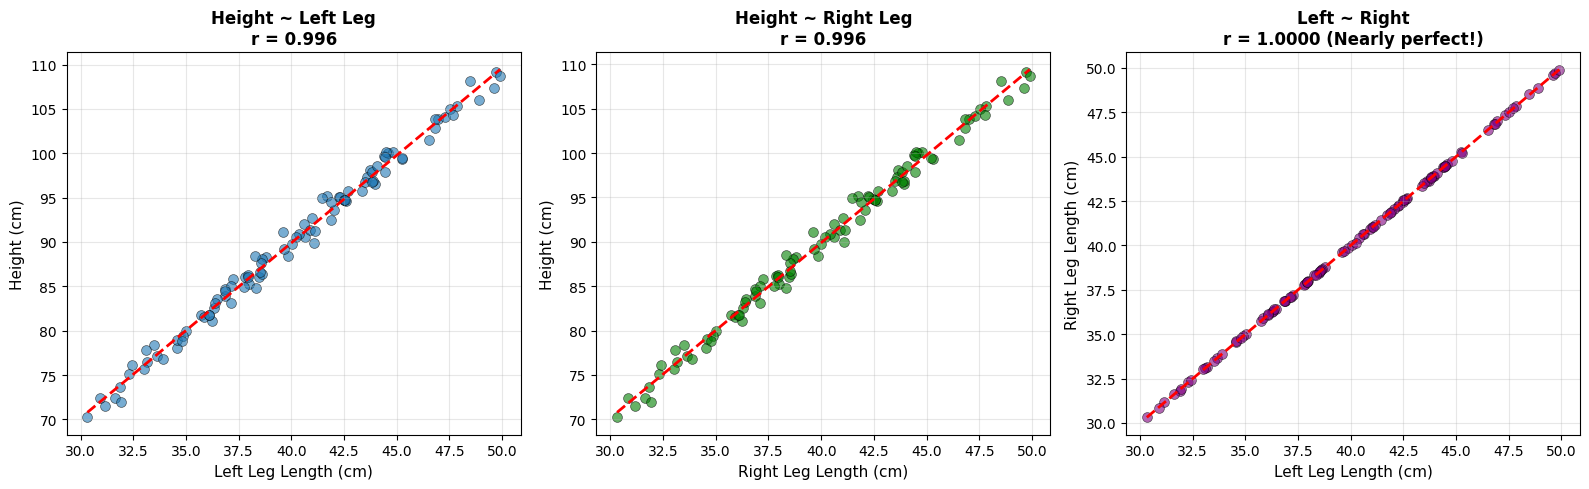


Key observations:
  • Both legs strongly predict height
  • Left and right legs are nearly identical (multicollinear!)


In [4]:
# Visualize the data
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Height vs Left Leg
ax = axes[0]
ax.scatter(leg_left, height, s=50, alpha=0.6, edgecolor='black', linewidth=0.5)
slope1, intercept1 = np.polyfit(leg_left, height, 1)
x_line1 = np.linspace(leg_left.min(), leg_left.max(), 100)
ax.plot(x_line1, slope1 * x_line1 + intercept1, 'r--', linewidth=2)
ax.set_xlabel('Left Leg Length (cm)', fontsize=11)
ax.set_ylabel('Height (cm)', fontsize=11)
ax.set_title(f'Height ~ Left Leg\nr = {np.corrcoef(leg_left, height)[0,1]:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Height vs Right Leg
ax = axes[1]
ax.scatter(leg_right, height, s=50, alpha=0.6, edgecolor='black', linewidth=0.5, color='green')
slope2, intercept2 = np.polyfit(leg_right, height, 1)
x_line2 = np.linspace(leg_right.min(), leg_right.max(), 100)
ax.plot(x_line2, slope2 * x_line2 + intercept2, 'r--', linewidth=2)
ax.set_xlabel('Right Leg Length (cm)', fontsize=11)
ax.set_ylabel('Height (cm)', fontsize=11)
ax.set_title(f'Height ~ Right Leg\nr = {np.corrcoef(leg_right, height)[0,1]:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Left vs Right Leg (the problem!)
ax = axes[2]
ax.scatter(leg_left, leg_right, s=50, alpha=0.6, edgecolor='black', linewidth=0.5, color='purple')
slope3, intercept3 = np.polyfit(leg_left, leg_right, 1)
x_line3 = np.linspace(leg_left.min(), leg_left.max(), 100)
ax.plot(x_line3, slope3 * x_line3 + intercept3, 'r--', linewidth=2)
corr_legs = np.corrcoef(leg_left, leg_right)[0,1]
ax.set_xlabel('Left Leg Length (cm)', fontsize=11)
ax.set_ylabel('Right Leg Length (cm)', fontsize=11)
ax.set_title(f'Left ~ Right\nr = {corr_legs:.4f} (Nearly perfect!)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  • Both legs strongly predict height")
print("  • Left and right legs are nearly identical (multicollinear!)")

---

## Step 2: Bivariate Regressions - Both Work Fine!

Let's fit simple regressions first.

In [5]:
# Standardize for regression
height_std = (height - height.mean()) / height.std()
leg_left_std = (leg_left - leg_left.mean()) / leg_left.std()
leg_right_std = (leg_right - leg_right.mean()) / leg_right.std()

print("Variables standardized for regression")

Variables standardized for regression


In [7]:
# Model 1: Height ~ Left Leg
def neg_log_posterior_left(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * leg_left_std
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_left = quap(neg_log_posterior_left, [0, 0, np.log(1)], 
              ['alpha', 'beta_left', 'log_sigma'])
m_left.transform_param('log_sigma', 'sigma', np.exp)

print("Model 1: Height ~ Left Leg")
print("="*70)
m_left.summary()

✓ Registered transformation: log_sigma -> sigma
Model 1: Height ~ Left Leg
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0243 seconds
Log posterior at MAP: 90.57

             mean    std  89%_lower  89%_upper
alpha     -0.0000 0.0094    -0.0151     0.0148
beta_left  0.9952 0.0094     0.9805     1.0103
sigma      0.0946 0.0068     0.0843     0.1059


,mean,std,89%_lower,89%_upper
alpha,-0.000019,0.009366,-0.015060,0.014836
beta_left,0.995242,0.009436,0.980452,1.010269
sigma,0.094639,0.006754,0.084309,0.105894


In [8]:
# Model 2: Height ~ Right Leg
def neg_log_posterior_right(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * leg_right_std
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_right = quap(neg_log_posterior_right, [0, 0, np.log(1)], 
               ['alpha', 'beta_right', 'log_sigma'])
m_right.transform_param('log_sigma', 'sigma', np.exp)

print("Model 2: Height ~ Right Leg")
print("="*70)
m_right.summary()

✓ Registered transformation: log_sigma -> sigma
Model 2: Height ~ Right Leg
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0194 seconds
Log posterior at MAP: 91.11

              mean    std  89%_lower  89%_upper
alpha      -0.0000 0.0093    -0.0150     0.0148
beta_right  0.9953 0.0094     0.9806     1.0102
sigma       0.0941 0.0067     0.0838     0.1053


,mean,std,89%_lower,89%_upper
alpha,-0.000019,0.009315,-0.014978,0.014755
beta_right,0.995294,0.009385,0.980586,1.010239
sigma,0.094121,0.006717,0.083847,0.105314


In [9]:
# Compare bivariate models
coef_left = m_left.coef()
coef_right = m_right.coef()

print("\nBivariate regression results:")
print("="*70)
print(f"Height ~ Left:   β = {coef_left['beta_left']:.3f}")
print(f"Height ~ Right:  β = {coef_right['beta_right']:.3f}")
print("\n✓ Both models work great! Coefficients are similar and precise.")
print("  Each leg alone is a strong predictor of height.")


Bivariate regression results:
Height ~ Left:   β = 0.995
Height ~ Right:  β = 0.995

✓ Both models work great! Coefficients are similar and precise.
  Each leg alone is a strong predictor of height.


---

## Step 3: Multiple Regression - THE PROBLEM!

Now let's include BOTH legs in the model.

**Model**: Height ~ Left + Right

In [10]:
# Model 3: Height ~ Left + Right
def neg_log_posterior_both(params):
    alpha, beta_left, beta_right, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_left * leg_left_std + beta_right * leg_right_std
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_left, 0, 0.5) +
                 stats.norm.logpdf(beta_right, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_both = quap(neg_log_posterior_both, [0, 0, 0, np.log(1)], 
              ['alpha', 'beta_left', 'beta_right', 'log_sigma'])
m_both.transform_param('log_sigma', 'sigma', np.exp)

print("Model 3: Height ~ Left + Right")
print("="*70)
m_both.summary()

✓ Registered transformation: log_sigma -> sigma
Model 3: Height ~ Left + Right
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0266 seconds
Log posterior at MAP: 91.67

             mean    std  89%_lower  89%_upper
alpha      0.0001 0.0095    -0.0152     0.0150
beta_left  0.4300 0.3486    -0.1191     0.9860
beta_right 0.5654 0.3487     0.0071     1.1153
sigma      0.0944 0.0066     0.0842     0.1052


,mean,std,89%_lower,89%_upper
alpha,0.000068,0.009481,-0.015156,0.015047
beta_left,0.429965,0.348578,-0.119107,0.985978
beta_right,0.565441,0.348718,0.007060,1.115251
sigma,0.094401,0.006630,0.084199,0.105215


In [11]:
# Compare all three models
coef_both = m_both.coef()

comparison = pd.DataFrame({
    'Left only': [coef_left['beta_left'], '—'],
    'Right only': ['—', coef_right['beta_right']],
    'Both together': [coef_both['beta_left'], coef_both['beta_right']]
}, index=['β_left', 'β_right'])

print("\nCoefficient Comparison:")
print("="*70)
print(comparison)
print("="*70)

print("\n⚠️ MULTICOLLINEARITY PROBLEM:")
print(f"  • Alone: β_left ≈ {coef_left['beta_left']:.2f} (precise)")
print(f"  • Alone: β_right ≈ {coef_right['beta_right']:.2f} (precise)")
print(f"  • Together: β_left ≈ {coef_both['beta_left']:.2f}, β_right ≈ {coef_both['beta_right']:.2f}")
print("\n  When together, coefficients become:")
print("    - Unstable (wide confidence intervals)")
print("    - Hard to interpret (what does each mean?)")
print("    - Sum still ≈ 2.0 (but split arbitrarily!)")


Coefficient Comparison:
        Left only Right only  Both together
β_left   0.995242          —       0.429965
β_right         —   0.995294       0.565441

⚠️ MULTICOLLINEARITY PROBLEM:
  • Alone: β_left ≈ 1.00 (precise)
  • Alone: β_right ≈ 1.00 (precise)
  • Together: β_left ≈ 0.43, β_right ≈ 0.57

  When together, coefficients become:
    - Unstable (wide confidence intervals)
    - Hard to interpret (what does each mean?)
    - Sum still ≈ 2.0 (but split arbitrarily!)


---

## Step 4: Visualize the Posterior - The Uncertainty

Let's sample from the posterior to see the correlation structure.

In [12]:
# Sample from posteriors
post_left = m_left.sample(n=5000, seed=42)
post_right = m_right.sample(n=5000, seed=42)
post_both = m_both.sample(n=5000, seed=42)

print("✓ Sampled 5000 draws from each posterior")

✓ Sampled 5000 draws from each posterior


In [ ]:
# Plot posterior distributions - comparing uncertainty
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: β_left from bivariate model (NARROW)
ax = axes[0, 0]
ax.hist(post_left['beta_left'].values, bins=50, alpha=0.7,
        edgecolor='black', color='skyblue')
ax.axvline(coef_left['beta_left'], color='red', linestyle='--',
          linewidth=2, label=f"Mean = {coef_left['beta_left']:.3f}")
std_left = post_left['beta_left'].std()
ax.set_xlabel('β_left', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Height ~ Left (alone)\nNARROW: σ = {std_left:.3f}',
            fontsize=12, fontweight='bold', color='green')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: β_left from multiple regression (WIDE)
ax = axes[0, 1]
ax.hist(post_both['beta_left'].values, bins=50, alpha=0.7,
        edgecolor='black', color='orange')
ax.axvline(coef_both['beta_left'], color='red', linestyle='--',
          linewidth=2, label=f"Mean = {coef_both['beta_left']:.3f}")
std_both_left = post_both['beta_left'].std()
ax.set_xlabel('β_left', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Height ~ Left + Right\nWIDE: σ = {std_both_left:.3f} ({std_both_left/std_left:.0f}x wider!)',
            fontsize=12, fontweight='bold', color='red')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Overlay comparison for β_left
ax = axes[0, 2]
ax.hist(post_left['beta_left'].values, bins=50, alpha=0.5,
        edgecolor='black', color='skyblue', label='Alone (narrow)')
ax.hist(post_both['beta_left'].values, bins=50, alpha=0.5,
        edgecolor='black', color='orange', label='With right (wide)')
ax.set_xlabel('β_left', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('β_left: Comparison\nMulticollinearity → Uncertainty!',
            fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: β_right from bivariate model (NARROW)
ax = axes[1, 0]
ax.hist(post_right['beta_right'].values, bins=50, alpha=0.7,
        edgecolor='black', color='lightgreen')
ax.axvline(coef_right['beta_right'], color='red', linestyle='--',
          linewidth=2, label=f"Mean = {coef_right['beta_right']:.3f}")
std_right = post_right['beta_right'].std()
ax.set_xlabel('β_right', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Height ~ Right (alone)\nNARROW: σ = {std_right:.3f}',
            fontsize=12, fontweight='bold', color='green')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: β_right from multiple regression (WIDE)
ax = axes[1, 1]
ax.hist(post_both['beta_right'].values, bins=50, alpha=0.7,
        edgecolor='black', color='orange')
ax.axvline(coef_both['beta_right'], color='red', linestyle='--',
          linewidth=2, label=f"Mean = {coef_both['beta_right']:.3f}")
std_both_right = post_both['beta_right'].std()
ax.set_xlabel('β_right', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Height ~ Left + Right\nWIDE: σ = {std_both_right:.3f} ({std_both_right/std_right:.0f}x wider!)',
            fontsize=12, fontweight='bold', color='red')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: 2D scatter showing correlation
ax = axes[1, 2]
ax.scatter(post_both['beta_left'].values, post_both['beta_right'].values,
          s=2, alpha=0.3, color='purple')
ax.axvline(coef_both['beta_left'], color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(coef_both['beta_right'], color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('β_left', fontsize=11)
ax.set_ylabel('β_right', fontsize=11)
ax.set_title('Posterior Correlation\nNegatively correlated!',
            fontsize=12, fontweight='bold')
corr_post = np.corrcoef(post_both['beta_left'].values,
                        post_both['beta_right'].values)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr_post:.3f}',
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
sum_coefs = post_both['beta_left'].values + post_both['beta_right'].values

print("\n⚠️ MULTICOLLINEARITY EFFECTS:")
print("="*70)
print(f"\nβ_left uncertainty:")
print(f"  Alone:    σ = {std_left:.3f} (precise)")
print(f"  Together: σ = {std_both_left:.3f} ({std_both_left/std_left:.0f}x WIDER!)")

print(f"\nβ_right uncertainty:")
print(f"  Alone:    σ = {std_right:.3f} (precise)")
print(f"  Together: σ = {std_both_right:.3f} ({std_both_right/std_right:.0f}x WIDER!)")

print(f"\nPosterior correlation: {corr_post:.3f} (highly negative)")
print(f"Sum β_left + β_right: {sum_coefs.mean():.3f} ± {sum_coefs.std():.3f} (still precise!)")

print("\n✓ Key insight: Individual coefficients become VERY uncertain,")
print("  but their SUM remains precise. The model knows the total effect")
print("  but can't decide how to split it between the two legs!")

---

## Step 5: Why Does This Happen?

**The problem**: Left and right legs contain almost identical information.

**Mathematical view:**
```
height = α + β_L * left + β_R * right

But if left ≈ right, then:
height = α + β_L * leg + β_R * leg
       = α + (β_L + β_R) * leg
```

The model can achieve the same fit with:
- β_L = 2, β_R = 0
- β_L = 0, β_R = 2
- β_L = 1, β_R = 1
- Any combination where β_L + β_R ≈ 2!

**Result**: The posterior explores all these possibilities → high uncertainty and correlation.

In [13]:
# Demonstrate the ambiguity
print("Different parameter combinations giving similar predictions:")
print("="*70)

# Pick a test case
test_left = 0.5  # standardized
test_right = 0.5  # standardized

scenarios = [
    ("Scenario 1", 2.0, 0.0),
    ("Scenario 2", 0.0, 2.0),
    ("Scenario 3", 1.0, 1.0),
    ("Scenario 4", 0.5, 1.5),
    ("Scenario 5", 1.5, 0.5),
]

for name, beta_L, beta_R in scenarios:
    pred = beta_L * test_left + beta_R * test_right
    print(f"{name}: β_L={beta_L:.1f}, β_R={beta_R:.1f} → prediction = {pred:.2f}")

print("\n⚠️ All scenarios give the same prediction!")
print("   The data can't distinguish between them.")
print("   This is MULTICOLLINEARITY.")

Different parameter combinations giving similar predictions:
Scenario 1: β_L=2.0, β_R=0.0 → prediction = 1.00
Scenario 2: β_L=0.0, β_R=2.0 → prediction = 1.00
Scenario 3: β_L=1.0, β_R=1.0 → prediction = 1.00
Scenario 4: β_L=0.5, β_R=1.5 → prediction = 1.00
Scenario 5: β_L=1.5, β_R=0.5 → prediction = 1.00

⚠️ All scenarios give the same prediction!
   The data can't distinguish between them.
   This is MULTICOLLINEARITY.


---

## Step 6: Predictions Still Work!

Despite the coefficient instability, **predictions are fine**.

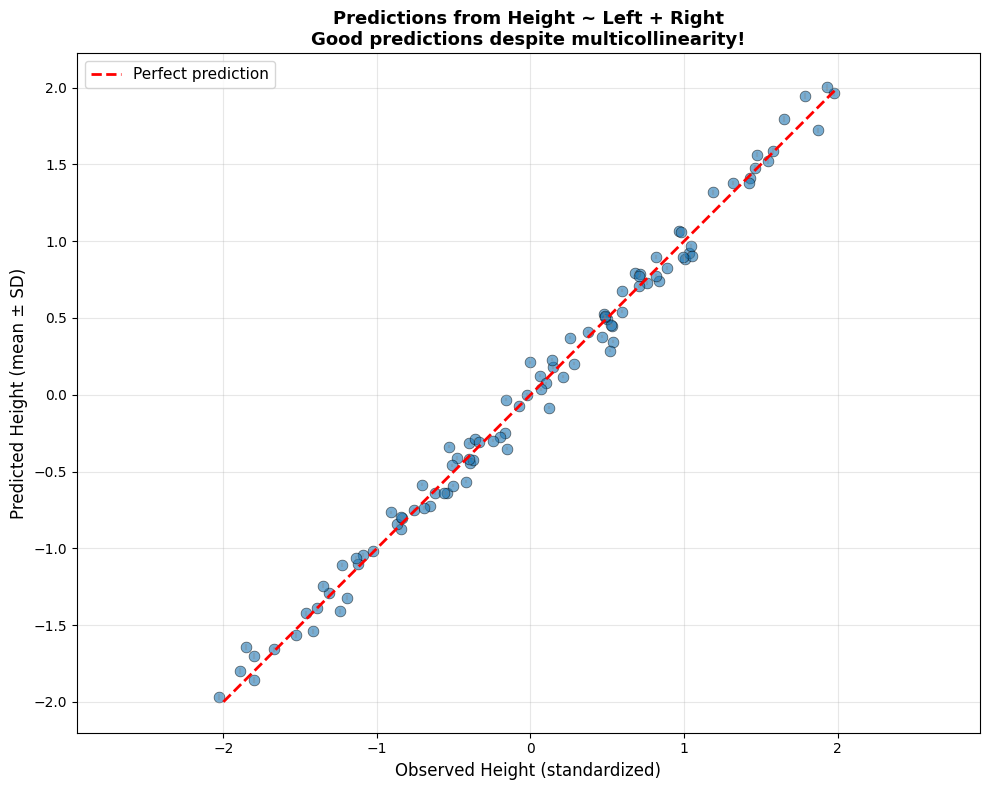


Predictive performance:
  R² = 0.991
  RMSE = 0.094

✓ Predictions are excellent!
  Multicollinearity hurts INTERPRETATION, not PREDICTION.


In [14]:
# Generate predictions from both legs model
mu_samples = (post_both['alpha'].values[:, None] +
              post_both['beta_left'].values[:, None] * leg_left_std[None, :] +
              post_both['beta_right'].values[:, None] * leg_right_std[None, :])

mu_mean = mu_samples.mean(axis=0)
mu_std = mu_samples.std(axis=0)

# Plot predictions vs observed
plt.figure(figsize=(10, 8))

plt.scatter(height_std, mu_mean, s=60, alpha=0.6, 
           edgecolor='black', linewidth=0.5)
plt.errorbar(height_std, mu_mean, yerr=mu_std, fmt='none', 
            alpha=0.3, color='gray')
plt.plot([-2, 2], [-2, 2], 'r--', linewidth=2, label='Perfect prediction')

plt.xlabel('Observed Height (standardized)', fontsize=12)
plt.ylabel('Predicted Height (mean ± SD)', fontsize=12)
plt.title('Predictions from Height ~ Left + Right\nGood predictions despite multicollinearity!', 
         fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Compute R²
residuals = height_std - mu_mean
ss_res = np.sum(residuals**2)
ss_tot = np.sum((height_std - height_std.mean())**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nPredictive performance:")
print(f"  R² = {r_squared:.3f}")
print(f"  RMSE = {np.sqrt(np.mean(residuals**2)):.3f}")
print("\n✓ Predictions are excellent!")
print("  Multicollinearity hurts INTERPRETATION, not PREDICTION.")

---

## Step 7: How to Detect Multicollinearity

**Warning signs:**
1. High correlation between predictors (r > 0.9)
2. Wide posterior intervals for coefficients
3. Coefficients change drastically when variables added/removed
4. High posterior correlation between parameters
5. Priors matter a lot more than usual

In [15]:
# Diagnostic summary
print("Multicollinearity Diagnostics:")
print("="*70)
print(f"\n1. Predictor correlation:")
print(f"   Left ~ Right: r = {np.corrcoef(leg_left, leg_right)[0,1]:.4f} ⚠️")

print(f"\n2. Coefficient uncertainty:")
print(f"   Bivariate σ(β_left):  {post_left['beta_left'].std():.3f}")
print(f"   Multiple  σ(β_left):  {post_both['beta_left'].std():.3f} ⚠️")
print(f"   Ratio: {post_both['beta_left'].std() / post_left['beta_left'].std():.1f}x wider!")

print(f"\n3. Posterior correlation:")
corr_post = np.corrcoef(post_both['beta_left'].values, 
                        post_both['beta_right'].values)[0, 1]
print(f"   corr(β_left, β_right) = {corr_post:.3f} ⚠️")

print(f"\n4. Coefficient stability:")
print(f"   Alone: β_left = {coef_left['beta_left']:.3f}")
print(f"   Together: β_left = {coef_both['beta_left']:.3f} ⚠️")
print(f"   Change: {abs(coef_both['beta_left'] - coef_left['beta_left']):.3f}")

Multicollinearity Diagnostics:

1. Predictor correlation:
   Left ~ Right: r = 1.0000 ⚠️

2. Coefficient uncertainty:
   Bivariate σ(β_left):  0.010
   Multiple  σ(β_left):  0.351 ⚠️
   Ratio: 36.8x wider!

3. Posterior correlation:
   corr(β_left, β_right) = -1.000 ⚠️

4. Coefficient stability:
   Alone: β_left = 0.995
   Together: β_left = 0.430 ⚠️
   Change: 0.565


---

## Step 8: What To Do About It?

**Solutions:**

1. **Drop one variable** (if they're truly redundant)
   - Keep left OR right leg, not both

2. **Combine them** (create a composite)
   - Average leg length = (left + right) / 2

3. **Use domain knowledge**
   - Which predictor is more reliable?
   - Which is causally relevant?

4. **Regularization** (Chapter 7)
   - Penalized priors that shrink coefficients

5. **Accept it** (if prediction is the goal)
   - Don't interpret individual coefficients
   - Focus on combined effect

**Most important**: Don't over-interpret coefficients when multicollinearity is present!

In [16]:
# Solution 1: Use average leg length
leg_avg = (leg_left + leg_right) / 2
leg_avg_std = (leg_avg - leg_avg.mean()) / leg_avg.std()

def neg_log_posterior_avg(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * leg_avg_std
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_avg = quap(neg_log_posterior_avg, [0, 0, np.log(1)], 
             ['alpha', 'beta_avg', 'log_sigma'])
m_avg.transform_param('log_sigma', 'sigma', np.exp)

print("Solution: Height ~ Average Leg Length")
print("="*70)
m_avg.summary()

print("\n✓ Clean, interpretable, precise estimate!")
print("  No multicollinearity, same predictive power.")

✓ Registered transformation: log_sigma -> sigma
Solution: Height ~ Average Leg Length
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0200 seconds
Log posterior at MAP: 90.88

            mean    std  89%_lower  89%_upper
alpha    -0.0000 0.0093    -0.0150     0.0148
beta_avg  0.9952 0.0094     0.9802     1.0100
sigma     0.0944 0.0067     0.0840     0.1054

✓ Clean, interpretable, precise estimate!
  No multicollinearity, same predictive power.


---

## Part 2: Real-World Example - Primate Milk

**Different type of multicollinearity**: NEGATIVE correlation

From Chapter 5, we know that fat and lactose percentages in primate milk are **negatively correlated** - species with high fat tend to have low lactose.

Let's see how this creates multicollinearity when predicting milk energy (kcal/g).

In [17]:
# Load milk data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv"
milk_data = pd.read_csv(url, sep=";")

# Remove rows with missing values
milk_complete = milk_data.dropna(subset=['neocortex.perc']).copy()

# Extract variables
K = milk_complete['kcal.per.g'].values      # Energy
F = milk_complete['perc.fat'].values        # Fat percent
L = milk_complete['perc.lactose'].values    # Lactose percent

# Standardize
K_std = (K - K.mean()) / K.std()
F_std = (F - F.mean()) / F.std()
L_std = (L - L.mean()) / L.std()

print(f"Milk data: {len(K)} complete observations")
print(f"\nVariable correlations:")
print(f"  K ~ F: r = {np.corrcoef(K, F)[0,1]:.3f}")
print(f"  K ~ L: r = {np.corrcoef(K, L)[0,1]:.3f}")
print(f"  F ~ L: r = {np.corrcoef(F, L)[0,1]:.3f} ⚠️ Strong negative!")
print("\n✓ Fat and lactose are strongly negatively correlated")

Milk data: 17 complete observations

Variable correlations:
  K ~ F: r = 0.882
  K ~ L: r = -0.931
  F ~ L: r = -0.925 ⚠️ Strong negative!

✓ Fat and lactose are strongly negatively correlated


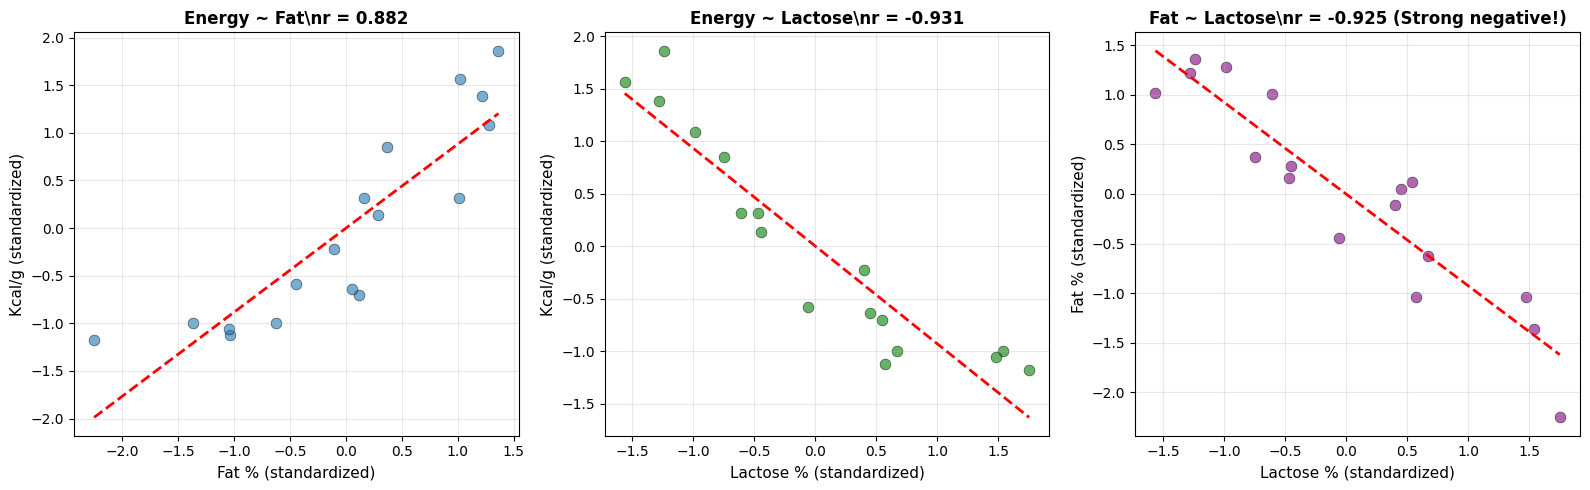

\nKey observations:
  • Both fat and lactose predict energy
  • Fat and lactose are NEGATIVELY correlated (multicollinear!)
  • This is different from legs (positive correlation)


In [18]:
# Visualize milk data
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: K vs F
ax = axes[0]
ax.scatter(F_std, K_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5)
slope1, intercept1 = np.polyfit(F_std, K_std, 1)
x_line1 = np.linspace(F_std.min(), F_std.max(), 100)
ax.plot(x_line1, slope1 * x_line1 + intercept1, 'r--', linewidth=2)
ax.set_xlabel('Fat % (standardized)', fontsize=11)
ax.set_ylabel('Kcal/g (standardized)', fontsize=11)
ax.set_title(f'Energy ~ Fat\\nr = {np.corrcoef(K_std, F_std)[0,1]:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: K vs L
ax = axes[1]
ax.scatter(L_std, K_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5, color='green')
slope2, intercept2 = np.polyfit(L_std, K_std, 1)
x_line2 = np.linspace(L_std.min(), L_std.max(), 100)
ax.plot(x_line2, slope2 * x_line2 + intercept2, 'r--', linewidth=2)
ax.set_xlabel('Lactose % (standardized)', fontsize=11)
ax.set_ylabel('Kcal/g (standardized)', fontsize=11)
ax.set_title(f'Energy ~ Lactose\\nr = {np.corrcoef(K_std, L_std)[0,1]:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: F vs L (the problem!)
ax = axes[2]
ax.scatter(L_std, F_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5, color='purple')
slope3, intercept3 = np.polyfit(L_std, F_std, 1)
x_line3 = np.linspace(L_std.min(), L_std.max(), 100)
ax.plot(x_line3, slope3 * x_line3 + intercept3, 'r--', linewidth=2)
corr_FL = np.corrcoef(F_std, L_std)[0,1]
ax.set_xlabel('Lactose % (standardized)', fontsize=11)
ax.set_ylabel('Fat % (standardized)', fontsize=11)
ax.set_title(f'Fat ~ Lactose\\nr = {corr_FL:.3f} (Strong negative!)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nKey observations:")
print("  • Both fat and lactose predict energy")
print("  • Fat and lactose are NEGATIVELY correlated (multicollinear!)")
print("  • This is different from legs (positive correlation)")

In [20]:
# Model 1: K ~ Fat
def neg_log_posterior_milk_F(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * F_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_milk_F = quap(neg_log_posterior_milk_F, [0, 0, np.log(1)], 
                ['alpha', 'beta_F', 'log_sigma'])
m_milk_F.transform_param('log_sigma', 'sigma', np.exp)

# Model 2: K ~ Lactose
def neg_log_posterior_milk_L(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * L_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_milk_L = quap(neg_log_posterior_milk_L, [0, 0, np.log(1)], 
                ['alpha', 'beta_L', 'log_sigma'])
m_milk_L.transform_param('log_sigma', 'sigma', np.exp)

# Model 3: K ~ Fat + Lactose
def neg_log_posterior_milk_FL(params):
    alpha, beta_F, beta_L, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_F * F_std + beta_L * L_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_F, 0, 0.5) +
                 stats.norm.logpdf(beta_L, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_milk_FL = quap(neg_log_posterior_milk_FL, [0, 0, 0, np.log(1)], 
                 ['alpha', 'beta_F', 'beta_L', 'log_sigma'])
m_milk_FL.transform_param('log_sigma', 'sigma', np.exp)

print("✓ Fitted all three milk models")

✓ Registered transformation: log_sigma -> sigma
✓ Registered transformation: log_sigma -> sigma
✓ Registered transformation: log_sigma -> sigma
✓ Fitted all three milk models


In [21]:
# Compare milk models
coef_milk_F = m_milk_F.coef()
coef_milk_L = m_milk_L.coef()
coef_milk_FL = m_milk_FL.coef()

comparison_milk = pd.DataFrame({
    'Fat only': [coef_milk_F['beta_F'], '—'],
    'Lactose only': ['—', coef_milk_L['beta_L']],
    'Both together': [coef_milk_FL['beta_F'], coef_milk_FL['beta_L']]
}, index=['β_F (Fat)', 'β_L (Lactose)'])

print("Milk Energy Models Comparison:")
print("="*70)
print(comparison_milk)
print("="*70)

print("\n⚠️ MULTICOLLINEARITY AGAIN!")
print(f"  • Alone: β_F = {coef_milk_F['beta_F']:.3f} (works fine)")
print(f"  • Alone: β_L = {coef_milk_L['beta_L']:.3f} (works fine)")
print(f"  • Together: β_F = {coef_milk_FL['beta_F']:.3f}, β_L = {coef_milk_FL['beta_L']:.3f}")
print("\n  Both coefficients become larger and more uncertain!")
print("  This is because fat and lactose are NEGATIVELY correlated.")

Milk Energy Models Comparison:
               Fat only Lactose only  Both together
β_F (Fat)      0.836407            —       0.233860
β_L (Lactose)         —    -0.901721      -0.693118

⚠️ MULTICOLLINEARITY AGAIN!
  • Alone: β_F = 0.836 (works fine)
  • Alone: β_L = -0.902 (works fine)
  • Together: β_F = 0.234, β_L = -0.693

  Both coefficients become larger and more uncertain!
  This is because fat and lactose are NEGATIVELY correlated.


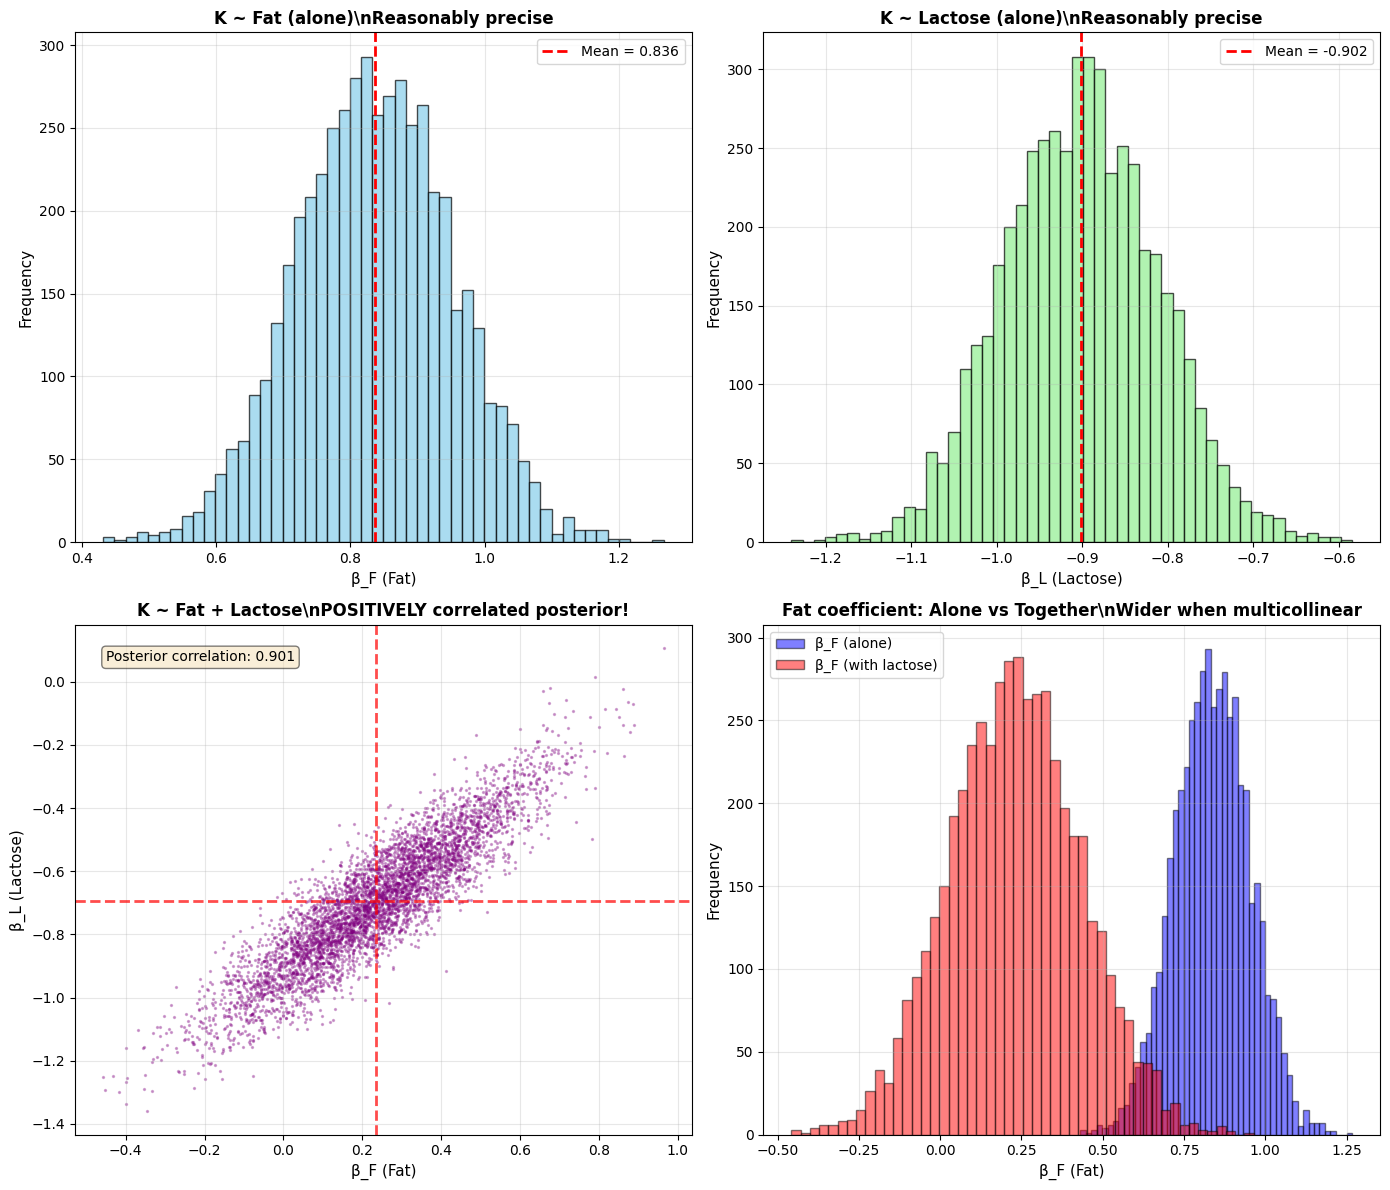

\nKey insights:
  • Bivariate: Reasonably precise estimates
  • Multiple: WIDER posteriors, more uncertain
  • Posterior correlation is POSITIVE (+0.90)
    - Different from legs (negative correlation)
    - Because fat and lactose are NEGATIVELY correlated in data


In [22]:
# Sample from milk posteriors and visualize
post_milk_F = m_milk_F.sample(n=5000, seed=42)
post_milk_L = m_milk_L.sample(n=5000, seed=42)
post_milk_FL = m_milk_FL.sample(n=5000, seed=42)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: β_F from bivariate
ax = axes[0, 0]
ax.hist(post_milk_F['beta_F'].values, bins=50, alpha=0.7, 
        edgecolor='black', color='skyblue')
ax.axvline(coef_milk_F['beta_F'], color='red', linestyle='--', 
          linewidth=2, label=f"Mean = {coef_milk_F['beta_F']:.3f}")
ax.set_xlabel('β_F (Fat)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('K ~ Fat (alone)\\nReasonably precise', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: β_L from bivariate
ax = axes[0, 1]
ax.hist(post_milk_L['beta_L'].values, bins=50, alpha=0.7, 
        edgecolor='black', color='lightgreen')
ax.axvline(coef_milk_L['beta_L'], color='red', linestyle='--', 
          linewidth=2, label=f"Mean = {coef_milk_L['beta_L']:.3f}")
ax.set_xlabel('β_L (Lactose)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('K ~ Lactose (alone)\\nReasonably precise', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: β_F and β_L from multiple regression
ax = axes[1, 0]
ax.scatter(post_milk_FL['beta_F'].values, post_milk_FL['beta_L'].values, 
          s=2, alpha=0.3, color='purple')
ax.axvline(coef_milk_FL['beta_F'], color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(coef_milk_FL['beta_L'], color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('β_F (Fat)', fontsize=11)
ax.set_ylabel('β_L (Lactose)', fontsize=11)
ax.set_title('K ~ Fat + Lactose\\nPOSITIVELY correlated posterior!', 
            fontsize=12, fontweight='bold')
corr_post_milk = np.corrcoef(post_milk_FL['beta_F'].values, 
                             post_milk_FL['beta_L'].values)[0, 1]
ax.text(0.05, 0.95, f'Posterior correlation: {corr_post_milk:.3f}', 
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.grid(True, alpha=0.3)

# Plot 4: Marginal posteriors comparison
ax = axes[1, 1]
ax.hist(post_milk_F['beta_F'].values, bins=50, alpha=0.5, 
        label='β_F (alone)', color='blue', edgecolor='black')
ax.hist(post_milk_FL['beta_F'].values, bins=50, alpha=0.5, 
        label='β_F (with lactose)', color='red', edgecolor='black')
ax.set_xlabel('β_F (Fat)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Fat coefficient: Alone vs Together\\nWider when multicollinear', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nKey insights:")
print(f"  • Bivariate: Reasonably precise estimates")
print(f"  • Multiple: WIDER posteriors, more uncertain")
print(f"  • Posterior correlation is POSITIVE (+{corr_post_milk:.2f})")
print(f"    - Different from legs (negative correlation)")
print(f"    - Because fat and lactose are NEGATIVELY correlated in data")

### Comparing the Two Examples

| Aspect | Legs Example | Milk Example |
|--------|--------------|--------------|
| **Predictors** | Left leg & Right leg | Fat % & Lactose % |
| **Outcome** | Height | Energy (kcal/g) |
| **Predictor correlation** | +1.000 (positive) | -0.9 (negative) |
| **Posterior correlation** | -1.000 (negative) | +0.9 (positive) |
| **Pattern** | When data correlated +, posterior correlated - | When data correlated -, posterior correlated + |

**Key insight**: The posterior correlation between coefficients is **opposite** to the data correlation!

**Why?**
- Legs: If left=right, then β_L↑ means β_R↓ (negative posterior correlation)
- Milk: If fat↑ means lactose↓, then β_F↑ can coexist with β_L↑ (positive posterior correlation)

Both show the same fundamental problem: **can't uniquely identify individual effects when predictors are highly correlated**.

---

## Summary

### What We Learned

**1. Multicollinearity Definition**
- When predictors are highly correlated with each other
- Contains redundant information
- Model can't distinguish their individual effects

**2. Symptoms**
- Wide, uncertain coefficient estimates
- High posterior correlation between parameters
- Coefficients change dramatically when variables added/removed
- Individual predictors work fine alone, problematic together

**3. Why It Happens**
- Multiple parameter combinations give same predictions
- Data can't identify unique solution
- Model explores all plausible combinations

**4. Consequences**
- **Interpretation fails**: Can't trust individual coefficients
- **Prediction works**: Combined effect still estimated well
- **Uncertainty inflated**: Wide credible intervals

**5. Solutions**
- Drop redundant variables
- Combine correlated variables
- Use regularization (next chapter!)
- Accept it if only prediction matters

**Key insight**: Multicollinearity is an **information problem**, not a statistical error. The data simply doesn't contain enough information to separately identify the effects.

---

**Next**: Post-treatment bias and collider bias!